In [1]:
%load_ext autoreload 
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import surp
import surp.gce_math as gcem
import arya
import vice

/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/__init__.py:141: UserWarning: Using un-released version of VICE
  warnings.warn("Using un-released version of VICE", UserWarning)


In [3]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.patheffects

In [4]:
calc_y = np.vectorize(surp.yields.calc_y)

In [6]:
import sys
sys.path.append("..")

In [7]:
from singlezone import run_singlezone, insideout

In [8]:
surp.set_yields()

## Loading and plotting a model

In [23]:
def load_model(name):
    """
    Finds the pickled model with either the given name or the parameters 
    and returns the csv summary
    """
    yield_params = surp.YieldParams.from_file("../../models/" + name + "/yield_params.toml")
    surp.set_yields(yield_params, verbose=False)
    
    file_name = "../../models/" + name + "/stars.csv"
    model =  pd.read_csv(file_name, index_col=0)

    return model

In [24]:
def load_gas_model(name):
    """
    Finds the pickled model with either the given name or the parameters 
    and returns the csv summary
    """
    
    file_name = "../../models/" + name + "/model.json"
    model =   surp.ViceModel.from_file(file_name)

    return model.history

In [25]:
gh = load_gas_model("fiducial/run")

In [26]:
model = load_model("fiducial/run")

In [27]:
def scatter_caah(model):
    """
    makes a scatter plot of [C/Mg] versus [Mg/H] for a given model (dataframe)
    """
    kwargs = dict(
        rasterized=True, ec="none", s=1, 
    )


    sns.scatterplot(model, x="MG_H", y="C_MG", hue="high_alpha", **kwargs)

    L = arya.Legend(labels=[r"low $\alpha$", r"high $\alpha$"], color_only=True, loc=4)
    for text in L.mpl_leg.get_texts():
        text.set_path_effects([mpl.patheffects.Stroke(linewidth=3, foreground='w'),
                           mpl.patheffects.Normal()])



    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.45, 0.15)
    plt.ylabel("[C/Mg]")
    plt.xlabel("[Mg/H]")

In [28]:

def scatter_caafe(model):
    kwargs = dict(
        rasterized=True, ec="none", s=1
    )
    
    sns.scatterplot(model, x="MG_FE", y="C_MG", hue="MG_H", hue_norm=(-0.5, 0.5), legend=False,  palette=plt.get_cmap(), **kwargs)
    plt.xlim(-0.08, 0.45)
    
    cax = plt.gca().inset_axes([1.05, 0., 0.05, 1])

    arya.Colorbar(clim=(-0.5, 0.5), label="[Mg/H]", cax=cax)

    plt.xlabel("[Mg/Fe]")

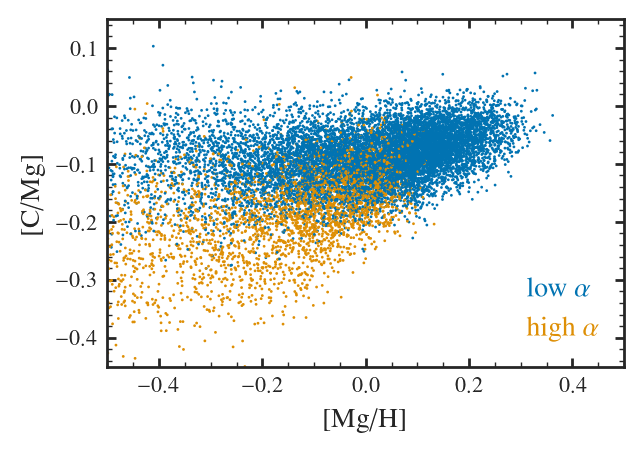

In [29]:
scatter_caah(model)

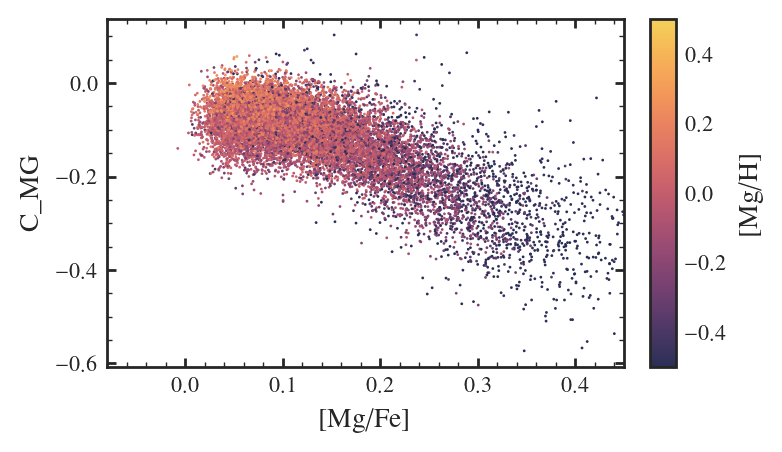

In [30]:
scatter_caafe(model)

In [31]:
def binned_caah(model):
    arya.medianplot(model[~model.high_alpha], "MG_H", "C_MG", 
                    numbins=20, color="k", stat="median")

def binned_caafe(model):
    arya.medianplot(model, "MG_FE", "C_MG", numbins=20, color="k",
                   stat="median")
    
def binned_caafe_slice(model, w=0, c0=-0.1):
    df = surp.filter_metallicity(model, c=-0.1, w=5)
    arya.medianplot(model, "MG_FE_true", "C_MG_true", numbins=12, color="k", 
        stat="median")


In [32]:
def plot_gas_today(h, x="MG_H", y="C_MG"):
    filt = h.time == np.max(h.time)
    filt &= h.R < 15
    df = h[filt]
    plt.scatter(df[x], df[y])

In [33]:
def plot_gas_caafe(h, R0=8.0, x="MG_FE", y="C_MG"):
    Rs = h.R.unique()
    R0 = Rs[np.argmin(np.abs(R0 - Rs))]
    print("using ", R0)

    filt = h.R == R0
    df = h[filt]
    plt.scatter(df[x], df[y])


In [34]:
def compare_coofe_gas(gh, sfh=None, tau_star=2.1): 
    plot_gas_caafe(gh)
    sz_caafe(sfh=sfh, color="k", tau_star=tau_star)
    plot_ssp_femg(0.016)
    

In [35]:
def compare_cooh_gas(model):
    plot_gas_today(model)
    plot_eq_caah()
    plt.xlabel("[Mg/H]")
    plt.ylabel("[C/Mg]")

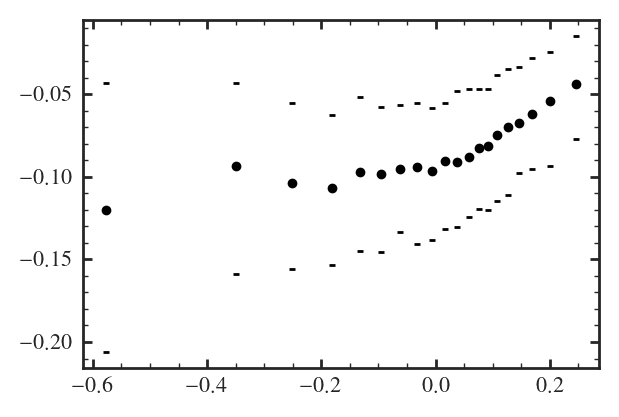

In [36]:
binned_caah(model)

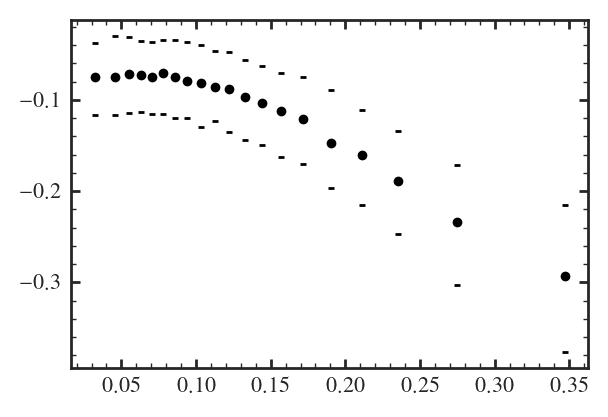

In [37]:
binned_caafe(model)

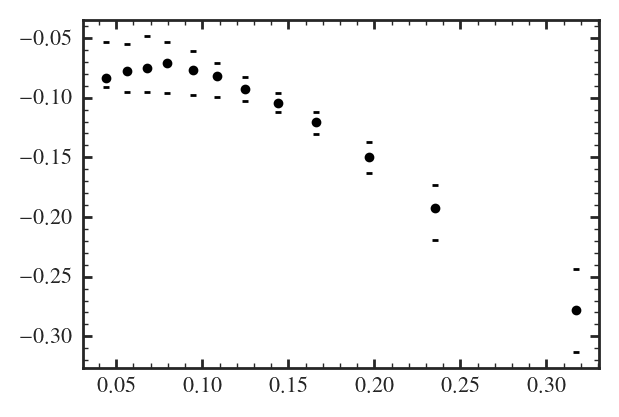

In [38]:
binned_caafe_slice(model)

### Eq predictions

In [39]:
eq_correction = 10**-0.00

def calc_eq_caah(M_H, **kwargs):
    Zs = gcem.MH_to_Z(M_H)
    ys = calc_y(Zs)
    ymg = calc_y(Zs, "mg")

    co = gcem.abund_ratio_to_brak(ys / ymg*eq_correction, "C", "MG")
    
    return co

def plot_eq_caah(M_H =np.linspace(-0.45, 0.45, 1000),  **kwargs):
    co = calc_eq_caah(M_H)
    
    plt.plot(M_H, co, label="equilibrium", color="k", lw=2, **kwargs)
    
    
def plot_eq_caafe(**kwargs):
    M_H = np.linspace(-0.45, 0.45, 1000)
    Zs = gcem.MH_to_Z(M_H)
    yc = calc_y(Zs)
    ymg = calc_y(Zs, "mg")
    yfe = calc_y(Zs, "fe")

    co = gcem.abund_ratio_to_brak(yc / ymg, "C", "MG")
    ofe = gcem.abund_ratio_to_brak(ymg/yfe, "mg", "fe")
    
    plt.plot(ofe, co, label="equilibrium", **kwargs)
    
def sz_caafe(eta=0.5, sfh=None, tau_star=3.2, **kwargs):
    if sfh is None:
        sfh = surp.simulation.sfh_models.insideout(tau_sfh=15)
    sz, h = run_singlezone(eta=eta, sfh=sfh, tau_star=tau_star)
    plt.plot(h.MG_FE, h.C_MG, **kwargs)
    return sz

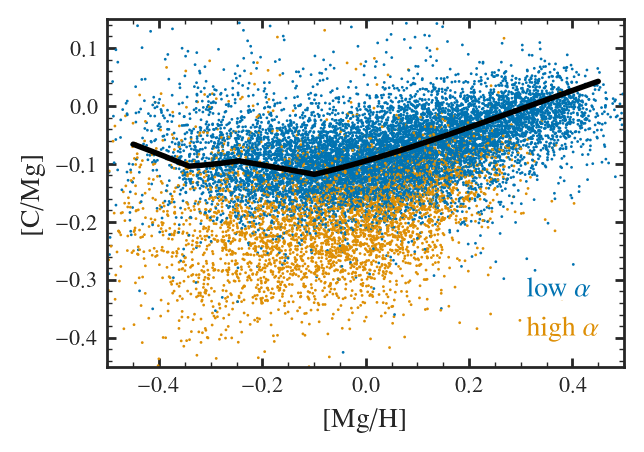

In [40]:
scatter_caah(surp.subgiants)
plot_eq_caah()


In [41]:
def compare_caah(model):
    #plot_data()
    scatter_caah(model)
    binned_caah(model)
    plot_eq_caah()
    
    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.6, 0.1)
    plt.xlabel("[Mg/H]")
    plt.ylabel("[C/Mg]")

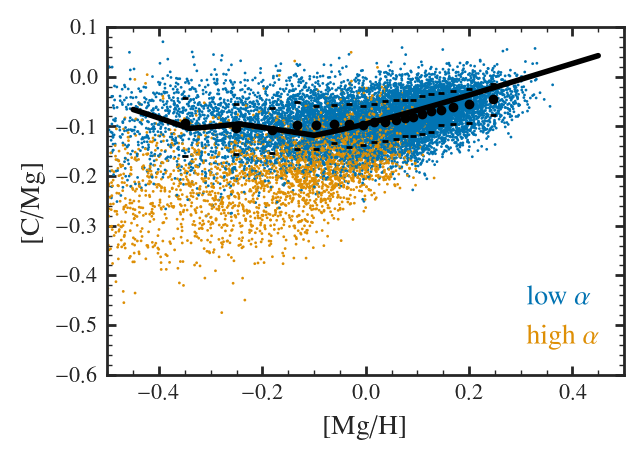

In [42]:
compare_caah(model)

In [43]:
def compare_caafe(model, sfh=insideout(tau_sfh=15), tau_star=2.2, **kwargs):
    scatter_caafe(model)
    binned_caafe_slice(model)
    plot_eq_caafe(lw=2, color="k")
    sz_caafe(label="singlezone", lw=2, color=arya.COLORS[2], sfh=sfh, tau_star=tau_star)

    plt.xlabel("[Mg/Fe]")
    plt.ylabel("[C/Mg]")

In [44]:
def plot_ssp_mgh(Z, **kwargs):
    m_c, times = vice.single_stellar_population("c", Z=Z, mstar=1)
    m_mg, times = vice.single_stellar_population("mg", Z=Z, mstar=1)

    c_mg = gcem.abund_ratio_to_brak(np.array(m_c)/m_mg, "C", "MG")
    fe_mg = gcem.abund_ratio_to_brak(np.array(m_mg), "Fe", "MG")
    plt.plot(mg_h, c_mg, **kwargs)


In [45]:
def plot_ssp_femg(Z, x_shift = 0, color=arya.COLORS[2],  **kwargs):
    m_c, times = vice.single_stellar_population("c", Z=Z, mstar=1)
    m_mg, times = vice.single_stellar_population("mg", Z=Z, mstar=1)
    m_fe, times = vice.single_stellar_population("fe", Z=Z, mstar=1)

    c_mg = gcem.abund_ratio_to_brak(np.array(m_c)/m_mg, "C", "MG")
    mg_fe = gcem.abund_ratio_to_brak(np.array(m_mg)/m_fe, "MG", "FE")
    plt.plot(mg_fe + x_shift, c_mg, color=color, **kwargs)


/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/pickles.py:305: UserWarning: C

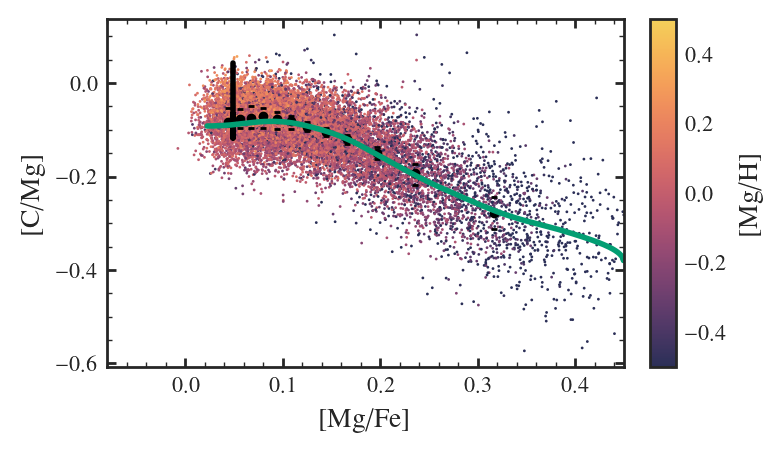

In [46]:
compare_caafe(model)

In [47]:
def compare_caafe_slice(model, c=-0.1, w=0.05, **kwargs):
    df = surp.filter_metallicity(model, c=c, w=w)
    scatter_caafe(df)
    binned_caafe_slice(model, c0=c, w=w)
    plot_eq_caafe(**kwargs)
    sz_caafe(label="singlezone", lw=2, color="k")
    plot_ssp_femg(Z=gcem.MH_to_Z(c))

    plt.xlabel("[Mg/Fe]")
    plt.ylabel("[C/Mg]")

/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/pickles.py:305: UserWarning: C

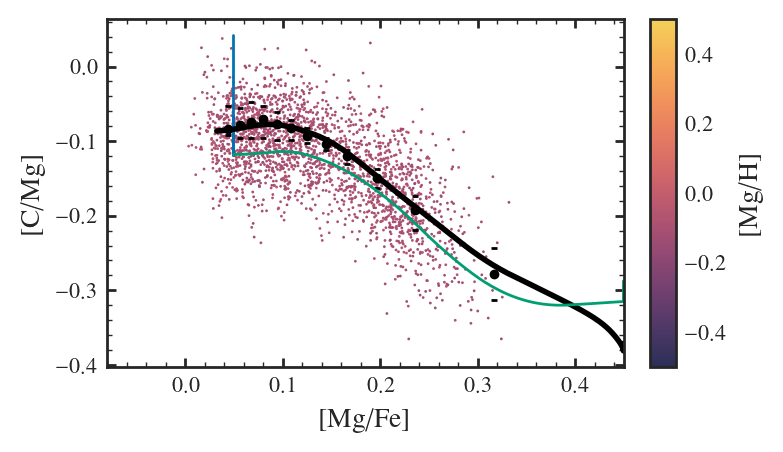

In [48]:
compare_caafe_slice(model)

In [49]:
def compare(model, sfh=None, tau_star=2.1):
    fig, axs = plt.subplots(1, 2, figsize=(7, 10/3), sharey=True, gridspec_kw={"wspace": 0}, dpi=250)

    
    plt.sca(axs[0])
    compare_caah(model)
    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.45, 0.15)
    
    
    plt.sca(axs[1])
    compare_caafe(model, sfh=sfh, tau_star=tau_star)
    plt.xlim(-0.08, 0.45)


In [50]:
def compare_gas(model, sfh=None, tau_star=2.1):
    fig, axs = plt.subplots(1, 2, figsize=(7, 10/3), sharey=True, gridspec_kw={"wspace": 0}, dpi=250)

    
    plt.sca(axs[0])
    compare_cooh_gas(model)
    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.45, 0.15)
    
    
    plt.sca(axs[1])
    compare_coofe_gas(model, sfh=sfh, tau_star=tau_star)
    plt.xlim(-0.08, 0.45)


/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/singlezone/singlezone.py:1797: VisibleRuntimeWarning: Functions of stellar mass and metallicity for asymptotic giant branch star yields may significantly increase the required integration time, especially for fine timestepping.
  return self.__c_version.run(output_times, capture = capture,
/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: c
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/pickles.py:305: UserWarning: Could not pickle function. The following attribute will not be saved with this output: mg
  warnings.warn("""\
/astro/dboyea/.local/lib/python3.11/site-packages/vice-1.4.0.dev0-py3.11-linux-x86_64.egg/vice/core/pickles.py:305: UserWarning: C

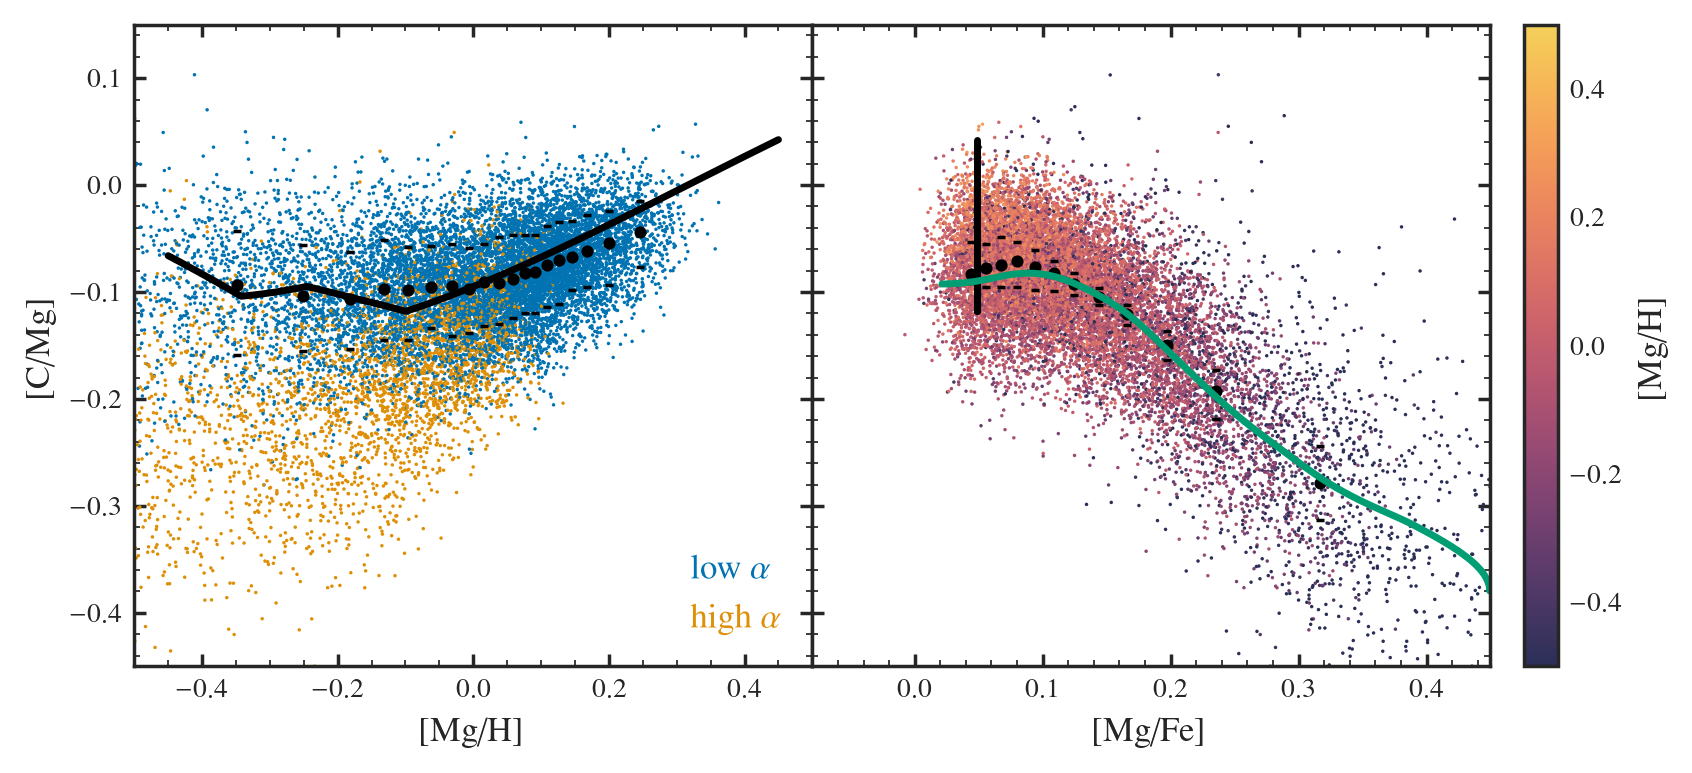

In [52]:
compare(model)

plt.savefig("figures/subgiants_equilibrium_reproduced.pdf")

# Actual comparisons

In [ ]:
h = load_gas_model("fiducial/run")

compare_gas(h)

In [ ]:
model = load_model("fruity/fz_0")

compare(model)

In [ ]:
model = load_model("fiducial/eta2")
compare(model)

In [ ]:
h = load_gas_model("fiducial/eta2")

compare_gas(h)

## twoinfall

In [ ]:
params = surp.MWParams.from_file("../models/fiducial/twoinfall_liam/params.toml")

In [ ]:
sfh = surp.simulation.star_formation_history.create_sfh_model(8, params)

In [ ]:
tau_star = 2.1

In [ ]:
model = load_model('fiducial/twoinfall_liam')
compare(model, sfh=sfh, tau_star = tau_star)

In [ ]:
h = load_gas_model("fiducial/twoinfall")

compare_gas(h, sfh=sfh, tau_star =tau_star)

## Al

In [ ]:
df = surp.filter_metallicity(model, c=-0.1, w=0.025)
plt.scatter(df.MG_FE, df.C_MG, s=0.3, alpha=0.3, label="model stars")
arya.medianplot(df, "MG_FE", "C_MG", binsize=100, color="k", label="median bins")
sz_caafe(color=arya.COLORS[2], lw=2, tau_star=2, tau_sfh=15, label="singlezone")
plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")
plt.title("fiducial metallicity filter")

plot_ssp_femg(gcem.MH_to_Z(-0.1), color=arya.COLORS[3], label="SSP (shifted by -0.05 dex in [Mg/Fe])", x_shift=-0.05)

plt.ylim(-0.4, 0)
arya.Legend(-1)

In [ ]:
df = model
plt.scatter(df.MG_FE, df.C_MG, s=0.3, alpha=0.3, label="model stars")
arya.medianplot(df, "MG_FE", "C_MG", binsize=300, color="k", label="median bins")
sz_caafe(color=arya.COLORS[2], lw=2, tau_star=2, tau_sfh=15, label="singlezone")
plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")
plt.title("no metallicity filter")

arya.Legend(-1)

In [ ]:
model = load_model("../models/C11_f0.2_Quadratic/")

In [ ]:
for c in [-0.3, -0.1, 0.1, 0.2]:
    df = surp.filter_metallicity(model, c=c, w=0.05)
    plt.scatter(df.MG_FE, df.C_MG, s=0.3, alpha=0.3, label="model stars")
    arya.medianplot(df, "MG_FE", "C_MG", binsize=200, color="k", label="median bins")
    sz_caafe(color=arya.COLORS[2], lw=2, tau_star=2, tau_sfh=15, label="singlezone")
    plt.xlabel("[Mg/Fe]")
    plt.ylabel("[C/Mg]")
    plt.title("fiducial metallicity filter")
    plot_ssp_femg(gcem.MH_to_Z(c), color=arya.COLORS[3], label="SSP (shifted by -0.05 dex in [Mg/Fe])", x_shift=-0.05)
    arya.Legend(-1)

    plt.ylim(-0.5, 0)
    plt.show()


In [ ]:
df = model
plt.scatter(df.MG_FE, df.C_MG, s=0.3, alpha=0.3, label="model stars")
arya.medianplot(df, "MG_FE", "C_MG", binsize=300, color="k", label="median bins")
sz_caafe(color=arya.COLORS[2], lw=2, tau_star=2, tau_sfh=15, label="singlezone")
plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")
plt.title("no metallicity filter")

arya.Legend(-1)

In [ ]:
compare_caafe(model)

In [ ]:
compare("C11_piecelin")

In [ ]:
compare("C11_oob")

In [ ]:
compare("K16_oob")

In [ ]:
compare("V13_oob")

In [ ]:
compare("P16_oob")

In [ ]:
compare("A_f0.2_zeta_agb-0.02_t_d0.3_tau_agb0.3")

In [ ]:
fiducial = surp.ViceModel.from_saved("../models/C11_f0.2/model.json")

In [ ]:
hm = arya.figure.colorbar.HueMap((-0.3, 0.3))

for c in np.linspace(-0.3, 0.3, 6):
    df = surp.filter_metallicity(surp.subgiants,w=0.05,c=c)
    arya.medianplot(df, "MG_FE", "C_MG", numbins=20, color=hm(c), errorbar=None)

plt.colorbar(label="[Mg/H]")
plt.xlabel("[Mg/Fe]")
plt.ylabel("[C/Mg]")
plt.title("Binned APOGEE trends")

# Gas phase equilibrium

In [ ]:
def plot_gas_eq(name):
    model = surp.ViceModel.from_file(f"../models/{name}/model.json")
    surp.set_yields(surp.YieldParams.from_file(f"../models/{name}/yield_params.json"))
    
    h = model.history
    h = h[h.time == np.max(h.time)]
    
    plt.plot(h.R, h["C_MG"], label="present day ISM")
    x = h.O_H
    y = calc_eq_caah(x)
    plt.plot(h.R, y, label="equilibrium")
    
    plt.xlim(2, 14)
    plt.ylim(-0.3, 0.1)
    plt.xlabel("Radius / kpc")
    plt.ylabel("[C/Mg]")

    arya.Legend(-1)

In [ ]:
plot_gas_eq("C11_f0.2")

In [ ]:
plot_gas_eq("C11_f0.2_Quadratic")

In [ ]:
plot_gas_eq("C11_f0.0")

# SSP

In [ ]:
def compare_ssp_caafe(name):
    model = load_model(name)

    MH=-0.1
    df = surp.filter_metallicity(model, c=MH)
    plt.scatter(df.MG_FE_true, df.C_MG_true, s=0.1, alpha=1, vmin=-0.5)
    for dMH in [ -0.15, -0.1, -0.05, 0, 0.05]:
        plot_ssp_femg(Z=gcem.MH_to_Z(MH - dMH), color=arya.COLORS[1], lw=1)

    plt.xlabel("[Mg/Fe]")
    plt.ylabel("[C/Mg]")

In [ ]:
compare_ssp_caafe("C11_f0.2")

In [ ]:
compare_ssp_caafe("K16_f0.2")

In [ ]:
compare_ssp_caafe("V13_f0.2")

In [ ]:
compare_ssp_caafe("P16_f0.2")

In [ ]:
compare_ssp_caafe("A_f0.2_zeta_agb-0.02_t_d0.3_tau_agb0.3")

In [ ]:
compare_ssp_caafe("A_f0.2_zeta_agb0.0_t_d0.15_tau_agb0.3")

# Singlezone

In [ ]:
import astropy.units as u

In [ ]:
sz, h = run_singlezone(dt=0.003)

In [ ]:
ele = "c"

y_c = vice.yields.ccsne.settings[ele]
if isinstance(y_c, float):
    y_cc = lambda x: y_c
else:
    y_cc = y_c
Mc = h[f"mass({ele})"].values * u.Msun
time = h.time.values * u.Gyr
time = time.to("yr")

r =h["r_eff"]
eta = h["eta_0"]
r = 0.4
denom =  (1 + eta - r).values
sfr = h.sfr.values * u.Msun / u.year
Zc = h[f"z({ele})"].values

dM_dep = -sfr * Zc * denom 
y_cc_t = [y_cc(z) for z in h["z"]]
dM_cc = sfr * y_cc_t
dM_c = np.gradient(Mc, time)


dM_agb = dM_c - dM_cc - dM_dep

f_agb = dM_agb / (dM_agb + dM_cc)


In [ ]:
dt = np.gradient(time)
M_agb = np.sum(dM_agb * dt)
M_cc = np.sum(dM_cc * dt)

In [ ]:
f_tot = M_agb / (M_agb + M_cc)

In [ ]:
plt.plot(Mc, (np.cumsum(dM_c * np.gradient(time)) - Mc) / Mc)

In [ ]:
plt.plot(time, dM_c, "k-", lw=2, label="total")
plt.plot(time, dM_cc, label="cc")
plt.plot(time, dM_dep, "--", label="depletion")
plt.plot(time, dM_agb, label="agb")
plt.xlabel("time [Gyr]")
plt.ylabel(r"$\dot{M}\quad [\rm M_\odot / yr]$")
arya.Legend(-1)

In [ ]:
tau_late = 3*u.Gyr
a_fe = -h["[fe/o]"]
plt.plot(time/1e9, a_fe)
idx = np.where(time > tau_late)[0][0]

fe_half = a_fe[idx]
plt.scatter(time[idx]/1e9, fe_half)
print(fe_half)

In [ ]:
plt.plot(time, f_agb)
plt.axhline(f_tot)

In [ ]:
plt.plot(time, Mc)

In [ ]:
h = fiducial.history
m_star = h["sfr"]*1e9 # Msun/yr (default)
denom = 1 + h["eta_0"] - h["r_eff"]
Mc = h["mass(c)"] # Msun

Zc = Mc / h["mgas"]
dt = h.time.unique()[1] # Gyr

smooth = 10
Mc_dot = np.concatenate([np.zeros(smooth), 
                         Mc[smooth:] - np.array(Mc[:-smooth]),
                        ]
                       )/(smooth*dt)
Z = h["z"]

y_cc = vice.yields.ccsne.settings["c"]
yc_cc = y_cc(Z)
y_c = (Mc_dot + denom*Zc*m_star)/m_star
y_c_agb = y_c - yc_cc
f_agb = np.array(y_c_agb/y_c)

X = np.reshape(f_agb, (200, -1))

## equilibrium corrections

### CCSNe

In [ ]:
vice.yields.ccsne.settings["fe"] = 0.
vice.yields.ccsne.settings["c"] = 0.


In [ ]:
sfh = surp.simulation.sfh_models.exp_sfh(tau_sfh=15)
r = 0.4
eta = 1.5

In [ ]:
h = run_singlezone(sfh=sfh, eta=eta)[1]

In [ ]:
plt.plot(h.time, h.sfr)
plt.plot(h.time, sfh(h.time))

In [ ]:
plt.plot(h.time, np.cumsum(h.sfr * np.gradient(h.time) * (1 - h.r_eff)) * 1e9, label="calculated")
plt.plot(h.time, h.mstar, label="onezone", ls="dashed")
plt.xlabel("time / gyr")
plt.ylabel(r"Mstar from SFR + $r_{\rm eff}$")
plt.legend()

In [ ]:
def calc_Mdot_cc_new(h, idx, ele="mg"):
    Mdotstar = h.sfr.iloc[idx] * 1e9
    y = vice.yields.ccsne.settings[ele]
    if not isinstance(y, float):
        y = y(h.z.iloc[idx])

    return Mdotstar * y

In [ ]:
def calc_Mdot_cc_new_ana(time, ele="mg"):
    y = vice.yields.ccsne.settings[ele]
    if not isinstance(y, (float, int)):
        y = y(h.z.iloc[idx])

    return sfr(time) * 1e9 * y
    

In [ ]:
def calc_Mdot_ele_out(h, idx, ele="mg"):
    Mmg = h[f"mass({ele})"].iloc[idx]
    Mdotstar = h.sfr.iloc[idx] * 1e9
    Mg = h.mgas.iloc[idx]
    Zmg = Mmg / Mg

    eta = h.eta_0.iloc[idx]
    r = 0.4 # h.r_eff.iloc[idx]
    return Mdotstar * Zmg * ( 1 + eta - r)

In [ ]:
Mdot_Mg_real = np.gradient(h["mass(mg)"], h.time, )

In [ ]:
Mdot_mg_calc = [calc_Mdot_cc_new(h, i) - calc_Mdot_ele_out(h, i, "mg") for i in range(len(h))]

In [ ]:
plt.plot(h.time, h.r_eff)

In [ ]:
plt.plot(h.time, Mdot_Mg_real)
plt.plot(h.time, Mdot_mg_calc)

In [ ]:
plt.plot(h.time, h["z(mg)"], label="vice")
plt.plot(h.time, np.cumsum(Mdot_mg_calc * np.gradient(h.time)) / h["mgas"], label="calculated")
plt.xlabel("time / gyr")
plt.ylabel("Z(Mg)")
plt.legend()

### the snefe correction

In [ ]:
def R_ia_unnorm(t):
    return np.where(t < 0.150, 0, t**-1.1)

tprime = np.linspace(0.001, 15, 10000)

denom = np.sum(R_ia_unnorm(tprime) * np.gradient(tprime))


def R_ia(t):
    return R_ia_unnorm(t) / denom


In [ ]:
def calc_nu_fe(h, idx):
    "Returns the current rate of Fe injection at the given time for a singlezone-like history"
    if idx < 3:
        return 0
        
    Mdotstar = h.sfr.values[:idx] * 1e9
    tprime = h.time.values[:idx]
    time = tprime[-1]

    dt = np.gradient(tprime)

    num = np.sum(Mdotstar * R_ia(time - tprime) * dt)

    return num / Mdotstar[-1]

In [ ]:
mdot_fe_real = np.gradient(h["mass(fe)"], h.time)

In [ ]:
nu_fe = np.array([calc_nu_fe(h, i) for i in range(len(h))])

In [ ]:
y_fe = vice.yields.sneia.settings["fe"]


In [ ]:
mdot_fe = [(calc_Mdot_cc_new(h, i, "fe") + nu_fe * y_fe * h.sfr.values*1e9)[i] - calc_Mdot_ele_out(h, i, "fe") for i in range(len(h))]
mdot_fe = np.array(mdot_fe)

In [ ]:
mdot_fe[np.isnan(mdot_fe)] = 0

In [ ]:
m_fe = np.cumsum(mdot_fe * np.gradient(h.time.values))

In [ ]:
plt.plot(h.time, h["mass(fe)"], label="simulation")
plt.plot(h.time, m_fe, label="calculated")
plt.xlabel("time / Gyr")
plt.ylabel("Mass(Fe)")
plt.legend()

In [ ]:
plt.plot(h.time, nu_fe)
plt.xlabel("time / Gyr")
plt.ylabel(r"$\nu_{\rm fe}^{\rm Ia}$")

In [ ]:
Rs = np.unique(gh.R)

In [ ]:
hs = [gh[np.isclose(gh.R, R)] for R in Rs]

In [ ]:
calc_nu_fe(hs[2], len(hs[0]))

In [ ]:
nu_fes = [calc_nu_fe(h, len(hs[0])) for h in hs]

### the agb correction

In [ ]:
@np.vectorize
def m_agb(t):
    return vice.mlr.larson1974(t, which="age")
    
@np.vectorize
def m_dot_agb(t, h=0.01):
    return (-m_agb(t) + m_agb(t+h)) / h 


@np.vectorize
def imf(m):
    return vice.imf.kroupa(m)



In [ ]:
m = np.linspace(0.08, 100, 10000)
dm = np.gradient(m)
h_norm = np.sum(m * imf(m) * dm)

def calc_hdot_agb(t):
    return -m_agb(t) * m_dot_agb(t) * imf(m_agb(t)) / h_norm

In [ ]:
def calc_mdot_agb(h, idx):
    "Returns the current rate of Fe injection at the given time for a singlezone-like history"
    if idx < 3:
        return 0
        
    Mdotstar = h.sfr.values[:(idx-1)] * 1e9
    tprime = h.time.values[:(idx-1)]
    time = h.time.values[idx]

    dt = np.gradient(tprime)

    y = vice.yields.agb.settings["c"]
    Z = h.z.values[:idx-1]

    m = m_agb(time-tprime)
    yc = np.array([y(mm, ZZ) for mm, ZZ in zip(m, Z)])

    hdot = calc_hdot_agb(time - tprime) 

    return np.sum( yc * Mdotstar * hdot * dt)



In [ ]:
def calc_nu_c(h, idx):
    y0 = surp.yields.calc_y(h.z.values[idx])

    sfr = h.sfr.values[idx]*1e9

    return  calc_mdot_agb(h, idx) / y0 / sfr

In [ ]:
calc_mdot_agb(h, len(h) - 1)

In [ ]:
idx_c_max = len(h)

mdot_c_agb = [calc_mdot_agb(h, i) for i in range(0, idx_c_max)]

In [ ]:
mdot_c = [calc_Mdot_cc_new(h, i, "c") + mdot_c_agb[i] - calc_Mdot_ele_out(h, i, "c") for i in range(0, idx_c_max)]


In [ ]:
plt.plot(h.time, h["mass(c)"], label="onezone")
plt.plot(h.time.iloc[:idx_c_max], np.cumsum(mdot_c * np.gradient(h.time.iloc[:idx_c_max])), label="calculated")
plt.xlabel("time / gyr")
plt.ylabel("Mdot(c)")
plt.legend()

In [ ]:
plt.plot(h.time.iloc[:idx_c_max], mdot_c_agb / h.sfr.iloc[:idx_c_max] / 1e9 / [surp.yields.calc_y(z) for z in h.z.values[:idx_c_max]], label="calculated")
plt.xlabel("time / gyr")
plt.ylabel(r"$\nu_{\rm C}^{\rm AGB}$")


## As applied to full model

In [ ]:
calc_nu_c(hs[0], len(hs[0])-1)

In [ ]:
nu_cs = [calc_nu_c(h, len(hs[0])-1) for h in hs]

In [ ]:
plt.plot(Rs, nu_fes, label="Fe")
plt.plot(Rs, nu_cs, label="C")
plt.xlabel("R gal / kpc")
plt.ylabel("equilibrium correction")
plt.ylim(1, 2)
plt.legend()

In [ ]:
h0 = gh[gh.time == np.max(gh.time)]

In [ ]:
h1 = gh[gh.time == np.unique(gh.time)[-2]]

In [ ]:
plt.scatter(h0.R, h0.mgas / h0.sfr / 1e9)

In [ ]:
plt.scatter(h0.R, h0.eta_0)

In [ ]:
tau_sfh = -1 / (
    (h0.sfr.values - h1.sfr.values) / h0.sfr.values / (h0.time.values-h1.time.values))

In [ ]:
plt.scatter(h0.R,tau_sfh)

In [ ]:
tau_star=2
plt.scatter(h0.R, h0.z, label="gas phase")
plt.scatter(h0.R, 0.016/(1 + h0.eta_0 - r - tau_star/tau_sfh), s=1, label="Z eq")
plt.ylim(0, 0.1)
plt.xlim(0, 15.5)
plt.xlabel("R / kpc")
plt.ylabel("Z")
plt.legend()

In [ ]:
plt.scatter(h0.R, h0.r_eff)
plt.ylim(0, 1)
plt.axhline(r)
plt.xlabel("R / kpc")
plt.ylabel("r_eff")